<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/25_august_2021_fixes/C4/W3/assignment/C4_W3_Assignment_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.0


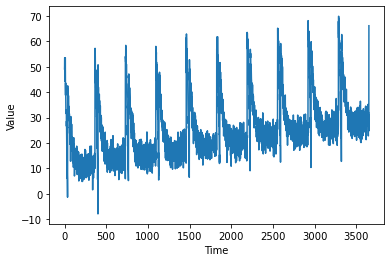

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# YOUR CODE HERE),
                      input_shape=[None]),
  ### START CODE HERE  
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  ### END CODE HERE 
  tf.keras.layers.Lambda(lambda x: x * 10.0)# YOUR CODE HERE)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Metal device set to: Apple M1 Pro


2022-03-21 13:39:22.783542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-21 13:39:22.783675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2022-03-21 13:39:24.180494: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-21 13:39:26.513295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:39:26.883817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:39:26.913813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:39:28.005626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:39:28.017194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:39:29.180210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

94/94 [==============================] - 10s 40ms/step - loss: 22.8210 - mae: 23.3209 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 3s 32ms/step - loss: 22.7876 - mae: 23.2876 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 3s 33ms/step - loss: 22.7499 - mae: 23.2498 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 3s 32ms/step - loss: 22.7074 - mae: 23.2073 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 3s 33ms/step - loss: 22.6598 - mae: 23.1597 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 3s 31ms/step - loss: 22.6062 - mae: 23.1061 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 3s 31ms/step - loss: 22.5459 - mae: 23.0458 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 3s 32ms/step - loss: 22.4780 - mae: 22.9779 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 3s 33ms/step - loss: 22.4014 - mae: 22.9012 - 

94/94 [==============================] - 3s 36ms/step - loss: 4.0950 - mae: 4.5623 - lr: 3.9811e-05
Epoch 74/100
94/94 [==============================] - 3s 36ms/step - loss: 3.9569 - mae: 4.4225 - lr: 4.4668e-05
Epoch 75/100
94/94 [==============================] - 4s 37ms/step - loss: 3.8575 - mae: 4.3230 - lr: 5.0119e-05
Epoch 76/100
94/94 [==============================] - 3s 36ms/step - loss: 3.7137 - mae: 4.1825 - lr: 5.6234e-05
Epoch 77/100
94/94 [==============================] - 3s 36ms/step - loss: 3.5770 - mae: 4.0435 - lr: 6.3096e-05
Epoch 78/100
94/94 [==============================] - 3s 37ms/step - loss: 3.4454 - mae: 3.9116 - lr: 7.0795e-05
Epoch 79/100
94/94 [==============================] - 4s 37ms/step - loss: 3.2647 - mae: 3.7273 - lr: 7.9433e-05
Epoch 80/100
94/94 [==============================] - 4s 37ms/step - loss: 3.2958 - mae: 3.7617 - lr: 8.9125e-05
Epoch 81/100
94/94 [==============================] - 3s 36ms/step - loss: 3.0830 - mae: 3.5456 - lr: 1.0000e

(1e-08, 0.0001, 0.0, 30.0)

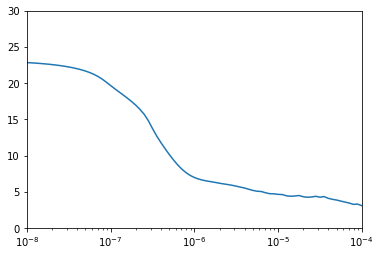

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# YOUR CODE HERE),
                      input_shape=[None]),
  ### START CODE HERE 
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  ### END CODE HERE 
  tf.keras.layers.Lambda(lambda x: x * 100.0)# YOUR CODE HERE)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=["mae"])# PUT YOUR LEARNING RATE HERE#, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3   

Epoch 1/500


2022-03-21 13:45:13.870076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:45:14.236756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:45:14.247583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:45:14.331751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:45:14.343529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:45:14.463262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 13:45:14.484010: I tensorflow/core/grappler/optimizers/cust

94/94 [==============================] - 7s 36ms/step - loss: 652.4077 - mae: 14.5326
Epoch 2/500
94/94 [==============================] - 3s 33ms/step - loss: 38.9494 - mae: 4.3488
Epoch 3/500
94/94 [==============================] - 3s 33ms/step - loss: 31.1125 - mae: 3.8553
Epoch 4/500
94/94 [==============================] - 3s 32ms/step - loss: 34.0668 - mae: 4.2206
Epoch 5/500
94/94 [==============================] - 3s 33ms/step - loss: 28.9304 - mae: 3.7489
Epoch 6/500
94/94 [==============================] - 3s 33ms/step - loss: 27.0456 - mae: 3.6141
Epoch 7/500
94/94 [==============================] - 3s 32ms/step - loss: 34.7677 - mae: 4.2819
Epoch 8/500
94/94 [==============================] - 3s 32ms/step - loss: 28.6876 - mae: 3.7472
Epoch 9/500
94/94 [==============================] - 3s 33ms/step - loss: 26.6183 - mae: 3.6073
Epoch 10/500
94/94 [==============================] - 3s 34ms/step - loss: 29.9696 - mae: 3.9210
Epoch 11/500
94/94 [=============================

94/94 [==============================] - 3s 35ms/step - loss: 21.3576 - mae: 3.1064
Epoch 86/500
94/94 [==============================] - 3s 34ms/step - loss: 22.2813 - mae: 3.1723
Epoch 87/500
94/94 [==============================] - 3s 33ms/step - loss: 24.5079 - mae: 3.4639
Epoch 88/500
94/94 [==============================] - 3s 33ms/step - loss: 21.3711 - mae: 3.0966
Epoch 89/500
94/94 [==============================] - 3s 32ms/step - loss: 23.5235 - mae: 3.3207
Epoch 90/500
94/94 [==============================] - 3s 32ms/step - loss: 22.6945 - mae: 3.2381
Epoch 91/500
94/94 [==============================] - 3s 32ms/step - loss: 23.1065 - mae: 3.3066
Epoch 92/500
94/94 [==============================] - 3s 32ms/step - loss: 23.8808 - mae: 3.3602
Epoch 93/500
94/94 [==============================] - 3s 31ms/step - loss: 22.1847 - mae: 3.2013
Epoch 94/500
94/94 [==============================] - 3s 31ms/step - loss: 22.1666 - mae: 3.2115
Epoch 95/500
94/94 [=======================

94/94 [==============================] - 3s 31ms/step - loss: 22.7875 - mae: 3.3003
Epoch 169/500
94/94 [==============================] - 3s 33ms/step - loss: 21.4077 - mae: 3.1293
Epoch 170/500
94/94 [==============================] - 3s 33ms/step - loss: 21.2251 - mae: 3.1223
Epoch 171/500
94/94 [==============================] - 3s 34ms/step - loss: 21.6796 - mae: 3.1744
Epoch 172/500
94/94 [==============================] - 3s 32ms/step - loss: 20.9140 - mae: 3.0633
Epoch 173/500
94/94 [==============================] - 3s 34ms/step - loss: 21.1919 - mae: 3.1035
Epoch 174/500
94/94 [==============================] - 3s 32ms/step - loss: 21.5600 - mae: 3.1602
Epoch 175/500
94/94 [==============================] - 3s 32ms/step - loss: 21.0703 - mae: 3.1179
Epoch 176/500
94/94 [==============================] - 3s 32ms/step - loss: 22.0193 - mae: 3.2044
Epoch 177/500
94/94 [==============================] - 3s 34ms/step - loss: 21.0524 - mae: 3.0987
Epoch 178/500
94/94 [=============

94/94 [==============================] - 3s 33ms/step - loss: 20.7365 - mae: 3.0765
Epoch 252/500
94/94 [==============================] - 3s 32ms/step - loss: 21.4205 - mae: 3.0964
Epoch 253/500
94/94 [==============================] - 3s 32ms/step - loss: 20.5896 - mae: 3.0426
Epoch 254/500
94/94 [==============================] - 3s 32ms/step - loss: 20.2191 - mae: 3.0094
Epoch 255/500
94/94 [==============================] - 3s 31ms/step - loss: 20.9192 - mae: 3.0992
Epoch 256/500
94/94 [==============================] - 3s 33ms/step - loss: 20.9488 - mae: 3.0979
Epoch 257/500
94/94 [==============================] - 3s 33ms/step - loss: 21.1750 - mae: 3.1154
Epoch 258/500
94/94 [==============================] - 3s 33ms/step - loss: 20.1857 - mae: 2.9961
Epoch 259/500
94/94 [==============================] - 3s 32ms/step - loss: 21.3829 - mae: 3.1270
Epoch 260/500
94/94 [==============================] - 3s 31ms/step - loss: 20.6905 - mae: 3.0501
Epoch 261/500
94/94 [=============

94/94 [==============================] - 3s 32ms/step - loss: 21.6391 - mae: 3.1649
Epoch 335/500
94/94 [==============================] - 3s 32ms/step - loss: 20.2172 - mae: 3.0381
Epoch 336/500
94/94 [==============================] - 3s 32ms/step - loss: 20.2725 - mae: 3.0206
Epoch 337/500
94/94 [==============================] - 3s 32ms/step - loss: 20.2793 - mae: 2.9891
Epoch 338/500
94/94 [==============================] - 3s 33ms/step - loss: 19.6414 - mae: 2.9260
Epoch 339/500
94/94 [==============================] - 3s 33ms/step - loss: 20.2370 - mae: 2.9956
Epoch 340/500
94/94 [==============================] - 3s 34ms/step - loss: 20.6477 - mae: 3.0482
Epoch 341/500
94/94 [==============================] - 3s 33ms/step - loss: 19.8172 - mae: 2.9616
Epoch 342/500
94/94 [==============================] - 3s 34ms/step - loss: 19.7807 - mae: 2.9617
Epoch 343/500
94/94 [==============================] - 3s 32ms/step - loss: 21.1856 - mae: 3.1363
Epoch 344/500
94/94 [=============

94/94 [==============================] - 3s 33ms/step - loss: 20.2538 - mae: 3.0166
Epoch 418/500
94/94 [==============================] - 3s 32ms/step - loss: 19.7123 - mae: 2.9402
Epoch 419/500
94/94 [==============================] - 3s 35ms/step - loss: 20.1169 - mae: 2.9993
Epoch 420/500
94/94 [==============================] - 3s 34ms/step - loss: 19.8772 - mae: 2.9963
Epoch 421/500
94/94 [==============================] - 3s 35ms/step - loss: 20.8587 - mae: 3.0848
Epoch 422/500
94/94 [==============================] - 3s 35ms/step - loss: 19.6230 - mae: 2.9435
Epoch 423/500
94/94 [==============================] - 3s 33ms/step - loss: 19.9093 - mae: 2.9840
Epoch 424/500
94/94 [==============================] - 3s 33ms/step - loss: 20.5707 - mae: 3.0673
Epoch 425/500
94/94 [==============================] - 3s 33ms/step - loss: 20.3864 - mae: 3.0210
Epoch 426/500
94/94 [==============================] - 3s 34ms/step - loss: 19.3787 - mae: 2.9099
Epoch 427/500
94/94 [=============

94/94 [==============================] - 3s 34ms/step - loss: 19.4106 - mae: 2.8952


2022-03-21 14:13:08.225664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 14:13:08.366176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 14:13:08.374375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 14:13:09.262552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 14:13:09.276177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


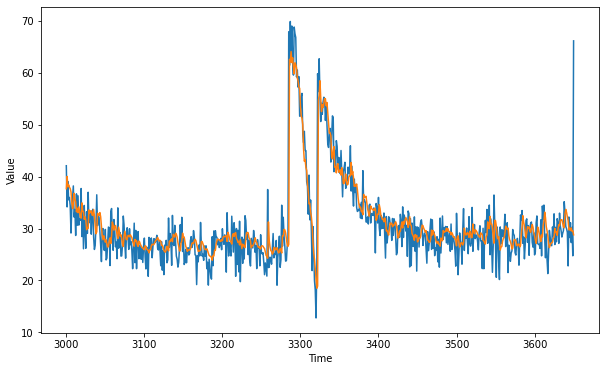

In [9]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

2.9633656

<Figure size 432x288 with 0 Axes>

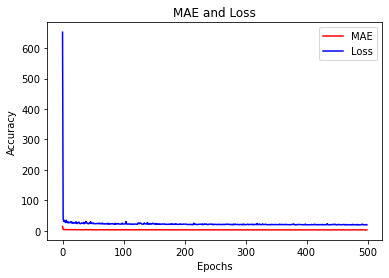

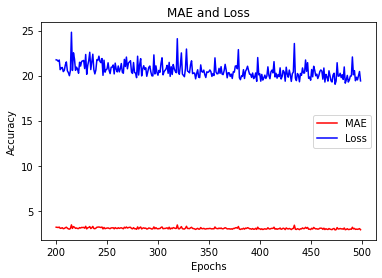

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()